In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.width', 130)    
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)    
pd.set_option('precision', 3)
import random
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
dark2 = plt.get_cmap('Dark2')  #dark2(0)

import seaborn as sns
sns.set(font_scale=1.3, style='whitegrid') # white, dark, whitegrid, darkgrid, ticks

import plotly.graph_objects as go
#import plotly.offline as py
#py.init_notebook_mode(connected=True)

plotly_color_list = ['#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
]

In [3]:
from tensorflow.keras import layers, models, callbacks
import tensorflow.keras.backend as K

In [4]:
!ln -s -f ../utils/utils.py utils.py
import utils

# Data

## Read data

In [5]:
data = pd.read_csv("../../data/train_FD001.txt", sep=r"\s+", index_col=False, header=None)
print(data.shape)
data.columns = ["unit", "cycle"] + ["setting"+str(i) for i in (1,2,3)] + ["s"+str(i) for i in range(1,22)]
units = data["unit"].unique(); 

(20631, 26)


In [6]:
display(data)

unit  cycle   setting1   setting2  setting3      s1      s2       s3       s4     s5     s6      s7       s8       s9  \
0         1      1 -7.000e-04 -4.000e-04     100.0  518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06  9046.19   
1         1      2  1.900e-03 -3.000e-04     100.0  518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04  9044.07   
2         1      3 -4.300e-03  3.000e-04     100.0  518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08  9052.94   
3         1      4  7.000e-04  0.000e+00     100.0  518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11  9049.48   
4         1      5 -1.900e-03 -2.000e-04     100.0  518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06  9055.15   
...     ...    ...        ...        ...       ...     ...     ...      ...      ...    ...    ...     ...      ...      ...   
20626   100    196 -4.000e-04 -3.000e-04     100.0  518.67  643.49  1597.98  1428.63  14.62  21.61  551.43  2388.19  9065.52   
20627   100    197 -1.600e-03 -5.000e-04     100.0  518.67  643.54  1604.50  1433.58  14.62  21.61  550.86  2388.23  9065.11   
20628   100    198  4.000e-04  0.000e+00     100.0  518.67  643.42  1602.46  1428.18  14.62  21.61  550.94  2388.24  9065.90   
20629   100    199 -1.100e-03  3.000e-04     100.0  518.67  643.23  1605.26  1426.53  14.62  21.61  550.68  2388.25  9073.72   
20630   100    200 -3.200e-03 -5.000e-04     100.0  518.67  643.85  1600.38  1432.14  14.62  21.61  550.79  2388.26  9061.48   

       s10    s11     s12      s13      s14    s15   s16  s17   s18    s19    s20     s21  
0      1.3  47.47  521.66  2388.02  8138.62  8.419  0.03  392  2388  100.0  39.06  23.419  
1      1.3  47.49  522.28  2388.07  8131.49  8.432  0.03  392  2388  100.0  39.00  23.424  
2      1.3  47.27  522.42  2388.03  8133.23  8.418  0.03  390  2388  100.0  38.95  23.344  
3      1.3  47.13  522.86  2388.08  8133.83  8.368  0.03  392  2388  100.0  38.88  23.374  
4      1.3  47.28  522.19  2388.04  8133.80  8.429  0.03  393  2388  100.0  38.90  23.404  
...    ...    ...     ...      ...      ...    ...   ...  ...   ...    ...    ...     ...  
20626  1.3  48.07  519.49  2388.26  8137.60  8.496  0.03  397  2388  100.0  38.49  22.974  
20627  1.3  48.04  519.68  2388.22  8136.50  8.514  0.03  395  2388  100.0  38.30  23.159  
20628  1.3  48.09  520.01  2388.24  8141.05  8.565  0.03  398  2388  100.0  38.44  22.933  
20629  1.3  48.39  519.67  2388.23  8139.29  8.539  0.03  395  2388  100.0  38.29  23.064  
20630  1.3  48.20  519.30  2388.26  8137.33  8.504  0.03  396  2388  100.0  38.37  23.052  

[20631 rows x 26 columns]

## Visualize sensor measurement - useful and useless sensors
Visualize each sensor for several selected units

In [7]:
#data.loc[data.unit.isin(selected_units), ['unit', 'cycle', 's2']]

In [8]:
selected_units = random.sample(data.unit.unique().tolist(), 5)
#print('Selected units: {:s}'.format(', '.join([str(u) for u in selected_units])))
print('Selected units:', selected_units)

Selected units: [93, 99, 65, 45, 16]


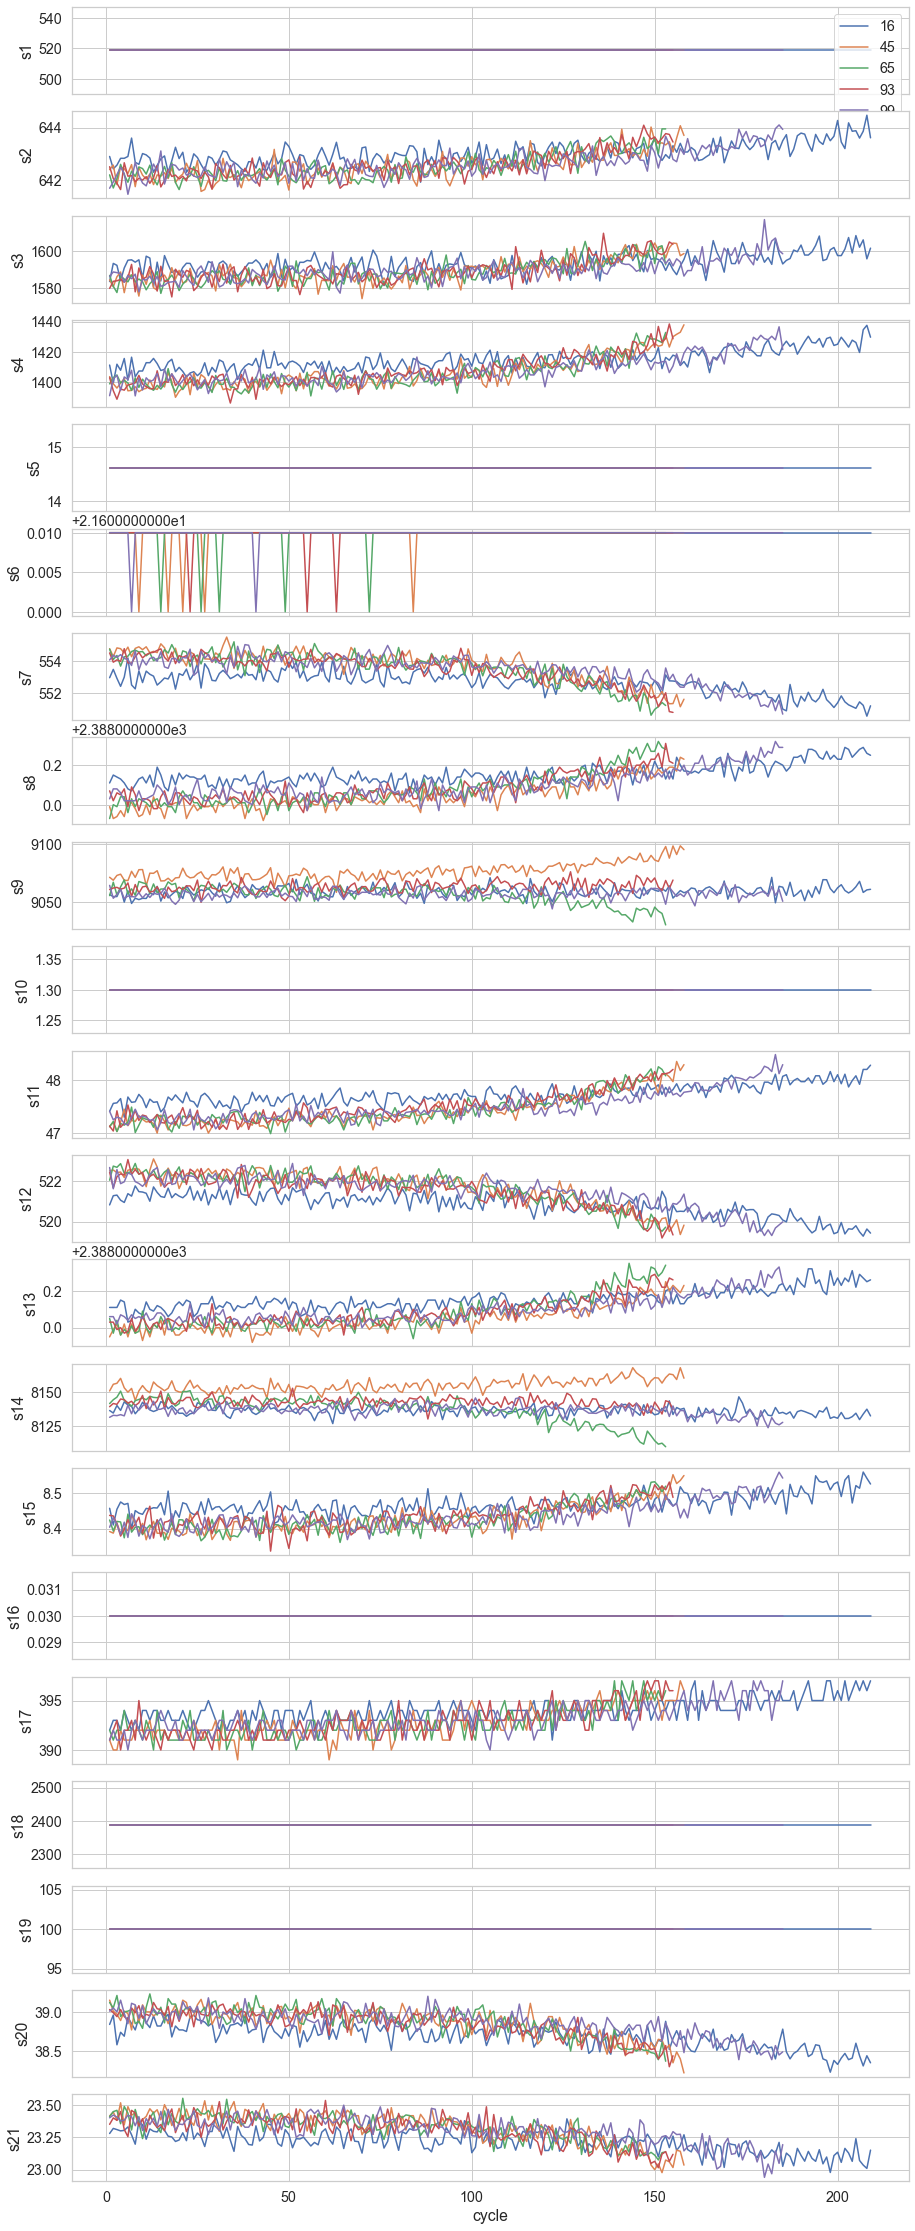

In [9]:
fig, ax = plt.subplots(21, 1, figsize=(15,40), sharex=True)
for s in range(1,22):
    sensor = 's'+str(s)
    tmp = data.loc[data.unit.isin(selected_units),['unit', 'cycle', sensor]]
    #tmp.plot(x='cycle', y=sensor, ax=ax[s-1], c='unit', cmap='tab10')
    for label, df in tmp.groupby('unit'):
        df.plot(x='cycle', y=sensor, ax=ax[s-1], label=label)
    ax[s-1].set_ylabel(sensor)
    if s>1:
        ax[s-1].get_legend().remove()
display(fig)
plt.close(fig)

Some sensors (1, 5, 10, 16, 18, 19) deliver no measurements and are useless. Sensor 's6' fluctuates between two values and is also useless. 
Thus I perform further analysis only using useful sensors.
    

In [10]:
useless_sensors = ["s" + str(i)  for i in [1,5,6,10,16,18,19]]
useful_sensors = ["s" + str(i)  for i in [2,3,4,7,8,9,11,12,13,14,15,17,20,21]]
data.drop(useless_sensors, axis=1, inplace=True)

We also see, that different units die at various cycle. What matters for predictive maintenance is number of cycles till death. Therefore we define our central values that we will be predicting - RUL.

## Define RUL - Remaining Useful Lifetime

In [11]:
### RUL = Reamining useful lifetime
max_cycle = data["cycle"].groupby(data['unit']).transform('max')
#max_cycle.shape; max_cycle.head()
data["RUL"] = max_cycle - data["cycle"]

In [12]:
data.head()

unit  cycle   setting1   setting2  setting3      s2       s3       s4      s7       s8       s9    s11     s12      s13  \
0     1      1 -7.000e-04 -4.000e-04     100.0  641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47  521.66  2388.02   
1     1      2  1.900e-03 -3.000e-04     100.0  642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49  522.28  2388.07   
2     1      3 -4.300e-03  3.000e-04     100.0  642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27  522.42  2388.03   
3     1      4  7.000e-04  0.000e+00     100.0  642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13  522.86  2388.08   
4     1      5 -1.900e-03 -2.000e-04     100.0  642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28  522.19  2388.04   

       s14    s15  s17    s20     s21  RUL  
0  8138.62  8.419  392  39.06  23.419  191  
1  8131.49  8.432  392  39.00  23.424  190  
2  8133.23  8.418  390  38.95  23.344  189  
3  8133.83  8.368  392  38.88  23.374  188  
4  8133.80  8.429  393  38.90  23.404  187

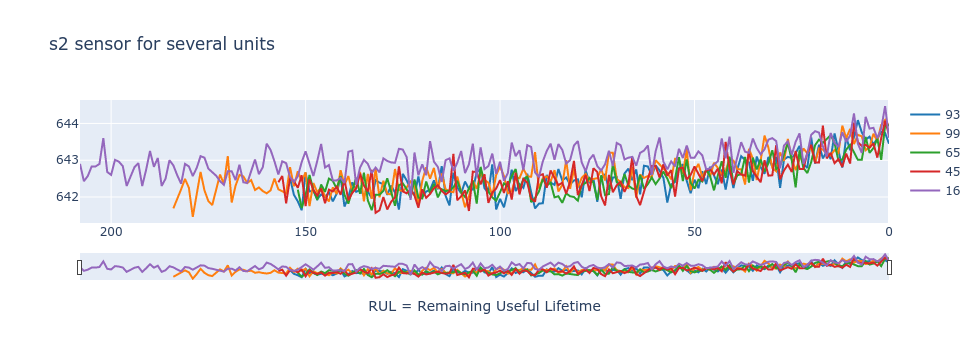

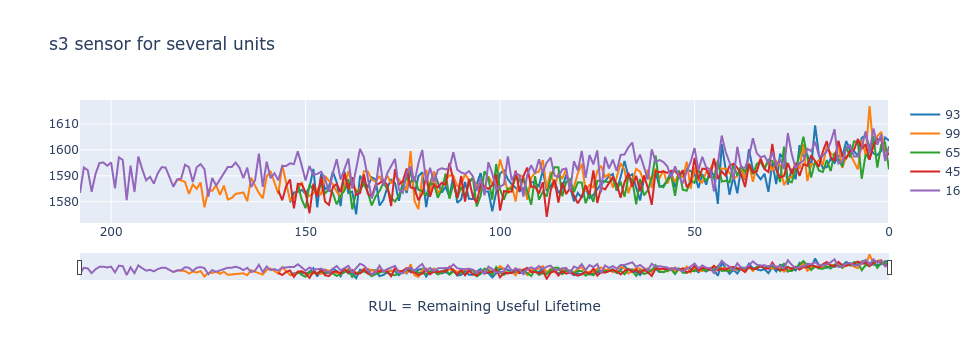

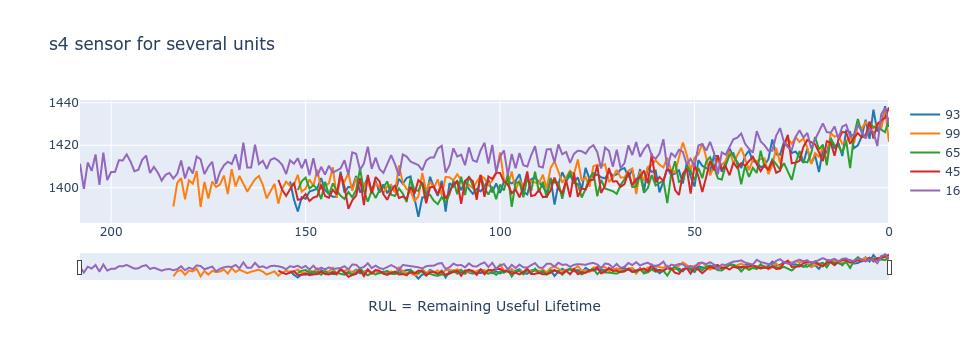

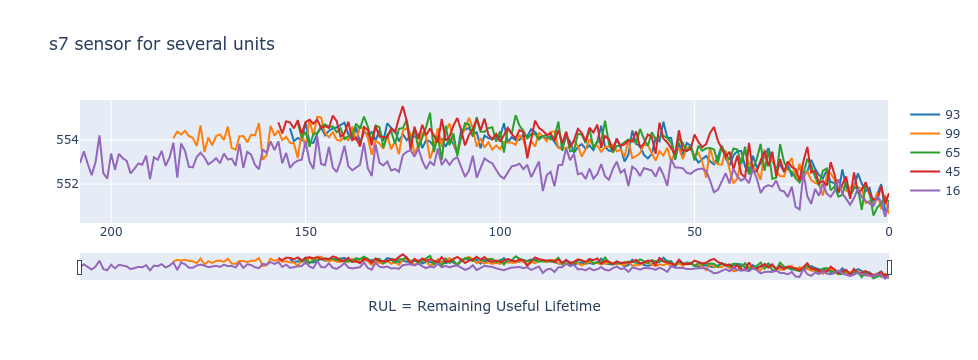

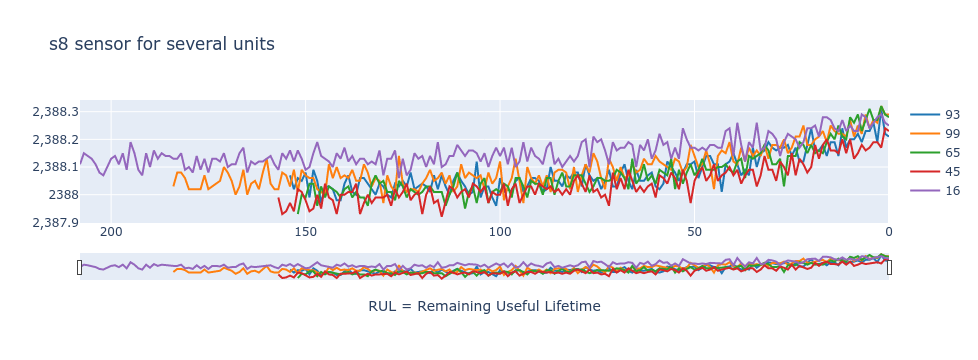

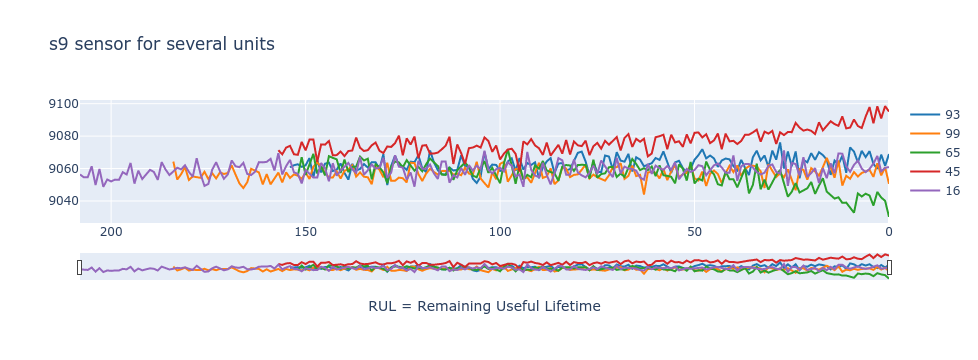

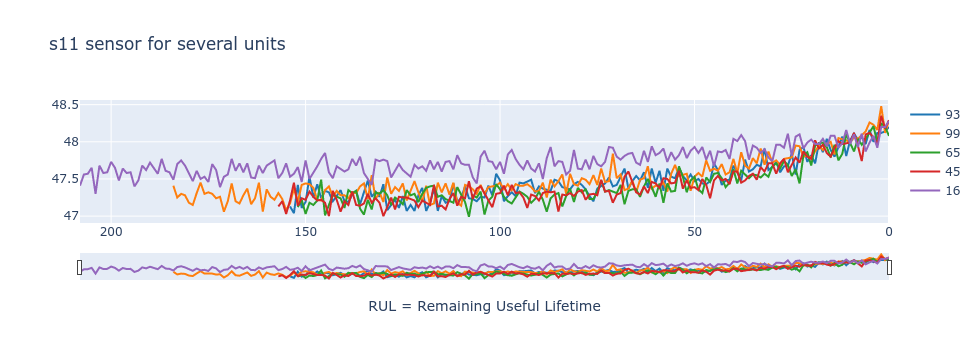

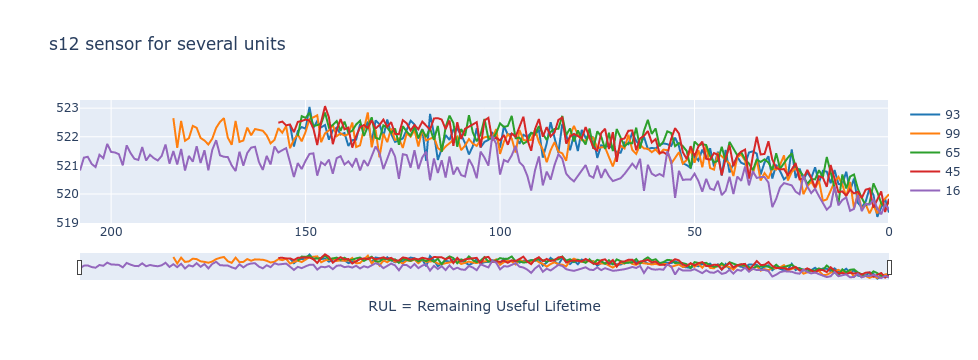

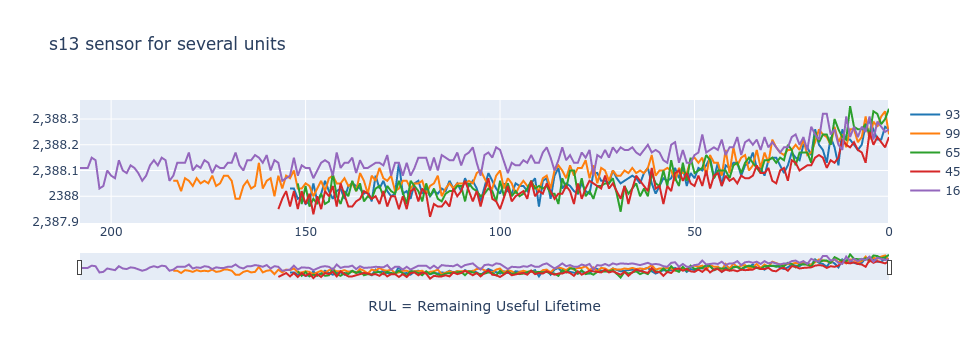

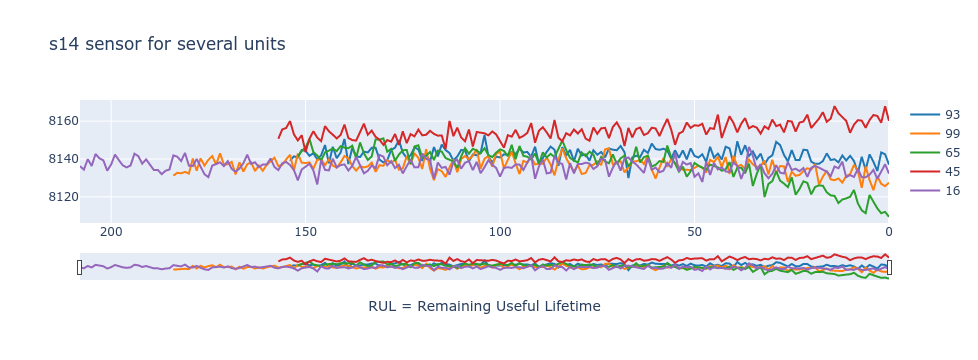

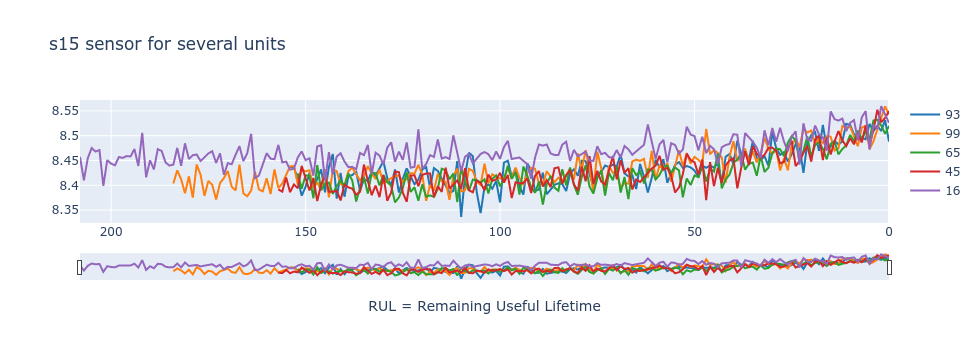

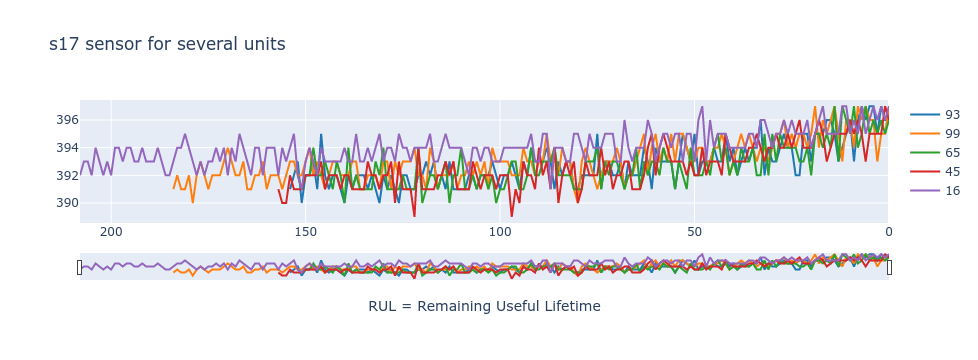

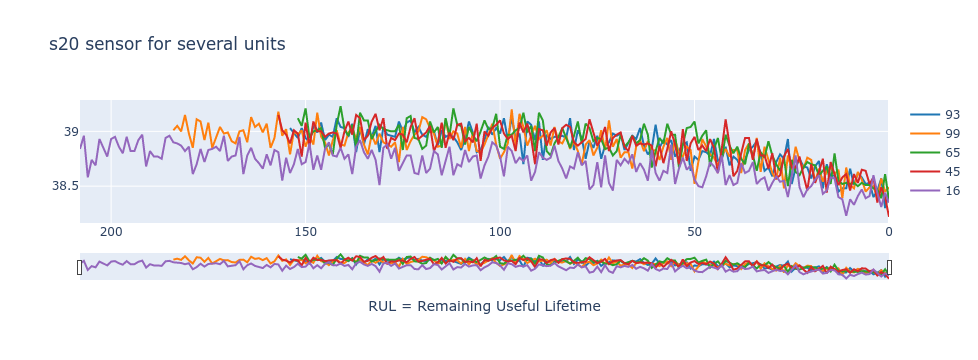

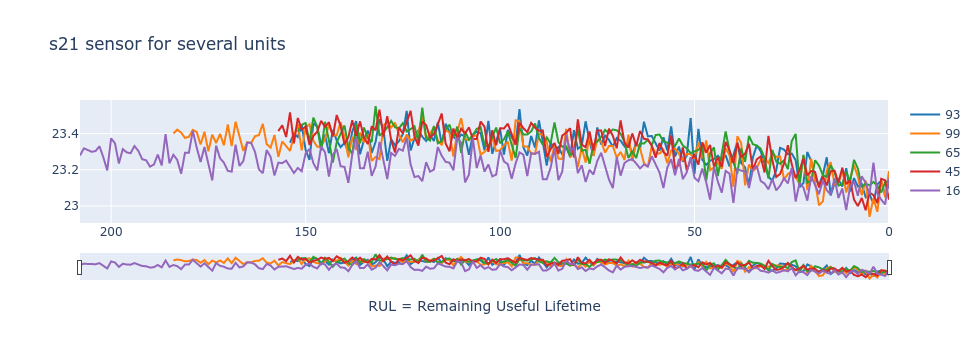

In [13]:
for sensor in useful_sensors:
    fig = go.Figure()
    for i,unit in enumerate(selected_units):
        tmp = data[data.unit==unit]
        fig.add_trace(go.Scatter(x=tmp.RUL, y=tmp[sensor], name=str(unit),
                                 line_color=plotly_color_list[i]))

        #fig.add_trace(go.Scatter(x=df.Date, y=df['AAPL.Low'], name="AAPL Low",
        #                         line_color='dimgray'))

    fig.update_xaxes(autorange="reversed", title_text="RUL = Remaining Useful Lifetime")
    fig.update_layout(title_text=f'{sensor:s} sensor for several units',
                      xaxis_rangeslider_visible=True)
    #py.iplot(fig, filename=f'useful-sensor-{sensor:s}')
    fig.show()

# Exploratory analysis

## Correlations between various sensors

In [14]:
#for unit in selected_units:
    #correlation = data.loc[data.unit==unit, useful_sensors].corr()
    #plt.matshow(correlation, cmap='RdBu')
    #plt.matshow(correlation, cmap='RdBu')
    #plt.imshow(correlation, cmap='RdBu')
    #plt.suptitle('Unit '+str(unit))

In [15]:
correlation = data.loc[:, useful_sensors].corr()
from biokit.viz import corrplot
c = corrplot.Corrplot(correlation)

<Figure size 432x288 with 0 Axes>

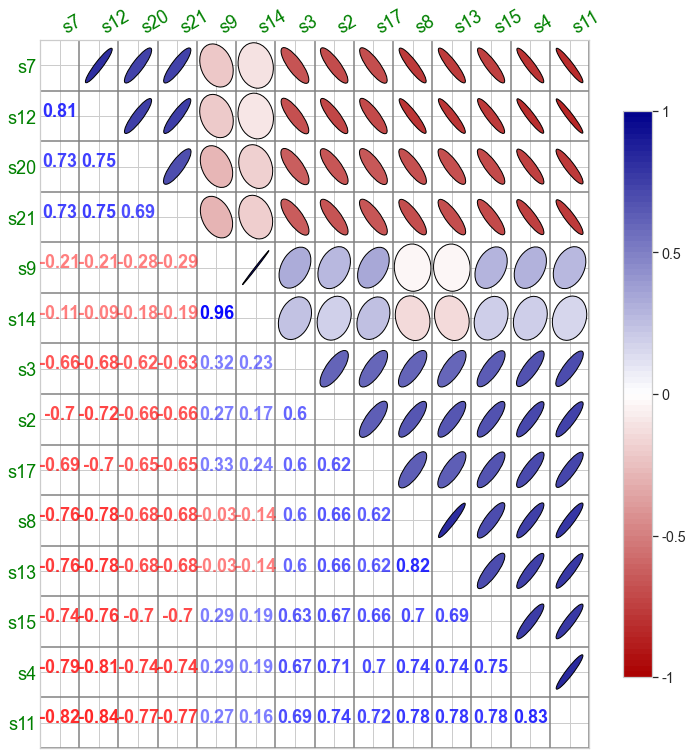

In [16]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning);

    fig, ax = plt.subplots(figsize=(11,11));
    c.plot(ax=ax, shrink=0.95, upper='ellipse', lower='text', fontsize=18, 
           label_color='green'); # method='ellipse',

In [17]:
#sns.corrplot(data.loc[data.unit==unit, useful_sensors])

Two groups of sensors: correlated within a group and anticollerated to each other

## Scaling sensor measurements

Nearly each Machine Learning model benefits from appropriate data scaling/normalization. This es especially true for Neural Networks, since it helps to avoid diverging gradient problem. But how the scaling should be done? 

### Question to discuss: what about MinMaxScaler ? 

In several approaches (for example, at [Hands-On-Artificial-Intelligence-for-IoT](https://github.com/PacktPublishing/Hands-On-Artificial-Intelligence-for-IoT) and also at [umbertogriffo](https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM)) to the Turbofan problem the scaling is done by using the MinMax scaler. But is this approach appropriate here? 

Let us think for a moment. As we saw in the exploratory analysis, each unit starts from a slightly different sensor measurement. And this measurement is intrinsically noisy - even for RUL > 100 the measured values vary a bit.

Close to the end of the unit's life, the measurement deviates significantly from its normal level. The deviation can be either positive or negative, growing rapidly close to the unit's failure. The final value of measurement significantly varies and essentially carries no useful information. 

### My choice: Scale sensor measurements by removing the baseline

Let us to capture the concept of _baseline_ - measurements that are _normal_  for each sensor. 
Then prozent deviations from this baseline will be an indicator of the unit RUL.

In [18]:
#utils.numeric_sensors
data.loc[:,utils.numeric_sensors]

s2       s3       s4      s7       s8       s9    s11     s12      s13      s14    s15  s17    s20     s21
0      641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47  521.66  2388.02  8138.62  8.419  392  39.06  23.419
1      642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49  522.28  2388.07  8131.49  8.432  392  39.00  23.424
2      642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27  522.42  2388.03  8133.23  8.418  390  38.95  23.344
3      642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13  522.86  2388.08  8133.83  8.368  392  38.88  23.374
4      642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28  522.19  2388.04  8133.80  8.429  393  38.90  23.404
...       ...      ...      ...     ...      ...      ...    ...     ...      ...      ...    ...  ...    ...     ...
20626  643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07  519.49  2388.26  8137.60  8.496  397  38.49  22.974
20627  643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04  519.68  2388.22  8136.50  8.514  395  38.30  23.159
20628  643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09  520.01  2388.24  8141.05  8.565  398  38.44  22.933
20629  643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39  519.67  2388.23  8139.29  8.539  395  38.29  23.064
20630  643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20  519.30  2388.26  8137.33  8.504  396  38.37  23.052

[20631 rows x 14 columns]

In [19]:
from IPython.display import HTML
def get_baseline(data):
    return data.loc[data.cycle<30, utils.useful_sensors].mean()
print('Baseline')
baseline = get_baseline(data)
#baseline
display(HTML(baseline.to_frame(name='baseline').T.round(1).to_html()))

Baseline


In [20]:
bdata = data.drop(utils.settings, axis=1).copy(deep=True)
bdata.loc[:,utils.numeric_sensors] = data[utils.numeric_sensors].div(baseline, axis=1)-1
bdata.tail()

unit  cycle     s2     s3     s4     s7         s8         s9    s11    s12        s13        s14    s15    s17    s20  \
20626   100    196  0.002  0.007  0.018 -0.005  5.468e-05  1.042e-03  0.015 -0.005  8.513e-05  2.651e-05  0.009  0.012 -0.011   
20627   100    197  0.002  0.011  0.022 -0.006  7.143e-05  9.967e-04  0.014 -0.004  6.838e-05 -1.087e-04  0.011  0.007 -0.016   
20628   100    198  0.002  0.010  0.018 -0.005  7.561e-05  1.084e-03  0.016 -0.004  7.675e-05  4.505e-04  0.017  0.015 -0.013   
20629   100    199  0.001  0.012  0.017 -0.006  7.980e-05  1.947e-03  0.022 -0.004  7.256e-05  2.342e-04  0.014  0.007 -0.016   
20630   100    200  0.002  0.009  0.021 -0.006  8.399e-05  5.959e-04  0.018 -0.005  8.513e-05 -6.668e-06  0.010  0.010 -0.014   

         s21  RUL  
20626 -0.017    4  
20627 -0.009    3  
20628 -0.018    2  
20629 -0.013    1  
20630 -0.013    0

In [21]:
## OLD version
def remove_baseline(df): 
    baseline = df[0:30].mean() # it seems to take into account only unit 1 (for each sensor)
    return (df - baseline)/baseline * 100

bdata = data.drop(utils.settings, axis=1).copy(deep=True)
### all data
bdata.loc[:,utils.numeric_sensors] = data[utils.numeric_sensors].transform(remove_baseline)
### each unit
#bdata.loc[:,utils.numeric_sensors] = data[utils.numeric_sensors].groupby(data["unit"]).transform(remove_baseline)
#
#bdata = data.copy()
#bdata.loc[:,utils.numeric_sensors] = utils.remove_baseline_each_unit(data.loc[:,utils.numeric_sensors])

In [22]:
bdata.head()

unit  cycle     s2     s3     s4     s7         s8     s9    s11    s12        s13    s14    s15    s17    s20    s21  RUL
0     1      1 -0.079  0.135  0.035  0.046 -9.771e-05 -0.038  0.396 -0.077 -1.117e-03  0.074  0.094  0.017  0.224  0.143  191
1     1      2 -0.028  0.268  0.217 -0.064 -9.352e-04 -0.062  0.438  0.042  9.771e-04 -0.014  0.240  0.017  0.070  0.163  190
2     1      3  0.003  0.027  0.292  0.028  7.398e-04  0.036 -0.027  0.069 -6.979e-04  0.007  0.074 -0.493 -0.058 -0.176  189
3     1      4  0.003 -0.300  0.126  0.062  1.996e-03 -0.002 -0.323  0.153  1.396e-03  0.015 -0.516  0.017 -0.238 -0.049  188
4     1      5  0.006 -0.297  0.437 -0.019 -9.771e-05  0.061 -0.006  0.025 -2.792e-04  0.014  0.211  0.272 -0.186  0.081  187

In [23]:
bdata.tail()

unit  cycle     s2     s3     s4     s7     s8     s9    s11    s12    s13    s14    s15    s17    s20    s21  RUL
20626   100    196  0.181  0.656  2.037 -0.483  0.005  0.175  1.665 -0.493  0.009  0.061  0.999  1.293 -1.238 -1.762    4
20627   100    197  0.189  1.067  2.391 -0.586  0.007  0.171  1.602 -0.456  0.007  0.048  1.216  0.782 -1.726 -0.967    3
20628   100    198  0.170  0.939  2.005 -0.571  0.007  0.180  1.707 -0.393  0.008  0.104  1.819  1.548 -1.367 -1.934    2
20629   100    199  0.140  1.115  1.887 -0.618  0.008  0.266  2.342 -0.458  0.008  0.082  1.513  0.782 -1.752 -1.375    1
20630   100    200  0.237  0.808  2.288 -0.598  0.008  0.131  1.940 -0.529  0.009  0.058  1.094  1.038 -1.546 -1.425    0

In [24]:
# each unit
# bdata.tail()

In [25]:
# each unit
#bdata.head()

# Extracting Signal from noisy measurements: dimensionality reduction

In [26]:
from sklearn.decomposition import PCA

## PCA - simple and straightforward 

In [27]:
pca = PCA()
pca.fit(bdata[utils.numeric_sensors])
print("Explained Variance", pca.explained_variance_)
print("Explained Variance Ratio",pca.explained_variance_ratio_)

Explained Variance [1.33961474 0.10822511 0.07508423 0.06608519 0.06272925 0.06058423
 0.0563477  0.04898158 0.00650009 0.00380478 0.00228417 0.0016808
 0.00000245 0.00000156]
Explained Variance Ratio [0.73126034 0.05907723 0.0409865  0.03607416 0.03424224 0.03307133
 0.03075872 0.02673775 0.00354823 0.00207693 0.00124687 0.0009175
 0.00000134 0.00000085]


##### Choosing the number of components

The first component dominates and explaines 70% of variance. Several following components seem to be equally important. Let us try to visualize the first three. 

##### Visualizing principal components - which are the signal?

In [28]:
pca_columns = ['pca'+str(i) for i in range(1,4)]
bdata_pca = pd.concat([bdata[['unit', 'cycle', 'RUL']],
                       pd.DataFrame(pca.transform(bdata[utils.numeric_sensors])[:,:3],
                                   index=bdata.index, columns=pca_columns)], axis=1)
bdata_pca.head()

unit  cycle  RUL   pca1   pca2   pca3
0     1      1  191 -1.020 -0.098  0.007
1     1      2  190 -0.781 -0.189  0.059
2     1      3  189 -1.056 -0.171  0.159
3     1      4  188 -1.415 -0.086  0.147
4     1      5  187 -0.831 -0.110  0.259

In [29]:
# for component in pca_columns:
#     fig = go.Figure()
#     for i,unit in enumerate(selected_units):
#         tmp = bdata_pca[bdata_pca.unit==unit]
#         fig.add_trace(go.Scatter(x=tmp.RUL, y=tmp[component], name=str(unit),
#                                  line_color=plotly_color_list[i]))

#         #fig.add_trace(go.Scatter(x=df.Date, y=df['AAPL.Low'], name="AAPL Low",
#         #                         line_color='dimgray'))

#     fig.update_xaxes(autorange="reversed")
#     fig.update_layout(title_text=f'{component:s} PCA component for several units',
#                       xaxis_rangeslider_visible=True)
#     fig.show()

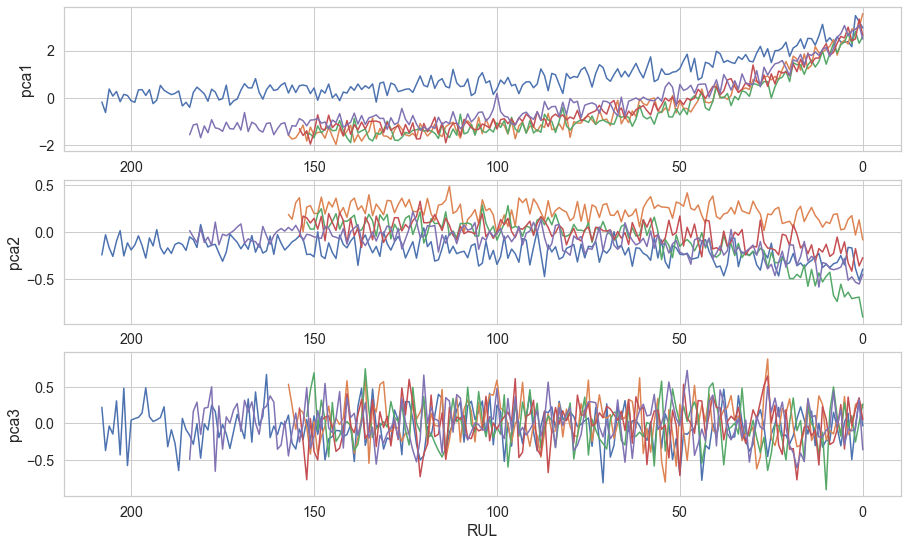

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(15,9))
for c in range(1,4):
    component = 'pca'+str(c)
    tmp = bdata_pca.loc[bdata_pca.unit.isin(selected_units),['unit', 'RUL', component]]
    #tmp.plot(x='cycle', y=sensor, ax=ax[s-1], c='unit', cmap='tab10')
    for label, df in tmp.groupby('unit'):
        df.plot(x='RUL', y=component, ax=ax[c-1], label=label)
    ax[c-1].invert_xaxis()
    ax[c-1].set_ylabel(component)
    if s>1:
        ax[c-1].get_legend().remove()
ax[0].set_xlabel('')
ax[1].set_xlabel('')
display(fig)
plt.close(fig)

The 1st and 2nd component look like signal, but are still very noisy. The third component looks like noise

##### Advantages and disadvantages of PCA

 + simple and straigtforward
    
 - implicit centering before applying the procedure: does it makes sense for our data?
 - the first components explains 70% of the variance, several following components at the level 4%-5%
 - no signal/noise separation

Why? Behind the PCA there is a latent variable model with implicit assumtion of  equal noise variance for all components

## Question to discuss:

* What are the advantages and disadvantages of PCA in this case?
* What other methods of dimentionality reduction would you use here?


# Baseline: Predicting RUL with linear models

## Question to discuss:

 * Below I use linear regression without train/validation split. What would you do? Why?

## The power of interactions

In the picture above The dependence between RUL and derived signals (2 PCA components) is clearly nonlinear.  Can we still making predctions using the interactions? 

In [31]:
### PCA
pca_columns = ['pca1', 'pca2']
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
lr = LinearRegression()
poly = PolynomialFeatures(degree=2, include_bias=False)
pipe = Pipeline(steps=[('poly', poly), ('lr', lr)])
pipe.fit(bdata_pca[pca_columns], bdata_pca['RUL'])
r2 = pipe.score(bdata_pca[pca_columns], bdata_pca['RUL'])
#r2

In [32]:
from IPython.display import Markdown as md
md("With a degree-2 polynomials we reached $R^2=%.3f$"%(r2))

With a degree-2 polynomials we reached $R^2=0.604$

## The power of transformation: how linear is linear dependence

Can we do better with the same linear model? Let us go one step back to understanding our goal and the engineering behind it. We know that the sensors are noisy. During the unit lifetime not the absolute value of the sensor is important, but its rate of change. As unit approaches its death, this rate of change accelerates. 


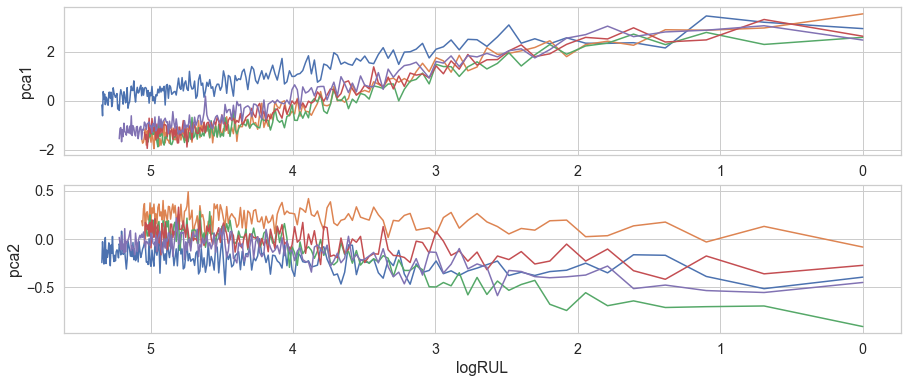

In [33]:
# PCA
bdata_pca['logRUL'] = bdata_pca['RUL'].apply(np.log1p)
fig, ax = plt.subplots(2, 1, figsize=(15,6))
for c in range(1,3):
    component = 'pca'+str(c)
    tmp = bdata_pca.loc[bdata_pca.unit.isin(selected_units),['unit', 'logRUL', component]]
    #tmp.plot(x='cycle', y=sensor, ax=ax[s-1], c='unit', cmap='tab10')
    for label, df in tmp.groupby('unit'):
        df.plot(x='logRUL', y=component, ax=ax[c-1], label=label)
    ax[c-1].set_ylabel(component)
    ax[c-1].invert_xaxis()
    if s>1:
        ax[c-1].get_legend().remove()
ax[0].set_xlabel('')
display(fig)
plt.close(fig)

In [34]:
pipe.fit(bdata_pca[pca_columns], bdata_pca['logRUL'])
r2_logRUL = pipe.score(bdata_pca[pca_columns], bdata_pca['logRUL'])

In [35]:
from IPython.display import Markdown as md
md("For a log-tranformed RUL $R^2=%.3f$ is significantly higher"%(r2_logRUL))

For a log-tranformed RUL $R^2=0.833$ is significantly higher

### Questions to discuss:

    * How unexpected it this linear dependence for logRUL? 
    * What considerations (if any) could hint on such result?
    * What are (if any) business reasons to predict logRUL instead of RUL?

### Linear model for logRUL

In [36]:
pipe.fit(bdata_pca[pca_columns], bdata_pca['logRUL'])
r2_logRUL = pipe.score(bdata_pca[pca_columns], bdata_pca['logRUL'])

In [37]:
from IPython.display import Markdown as md
md("For a log-tranformed RUL $R^2=%.3f$ is significantly higher"%(r2_logRUL))

For a log-tranformed RUL $R^2=0.833$ is significantly higher

# Guidelines to building production models

* input data are dirty: some of the sensors do not work, these measurements should be removed
* input data are noisy and redundant (highly-correlated): from over 10 useful sensors only 2 components seems to be relevant
* different sensors are on completely different scales and need to be scaled somehow
* the value to be predicted is not given in advanced, but should be defined and extracted from the training data
* from both business and mathematical perspectives not RUL, but rather logRUL should be predicted
* the baseline model - linear model- gives the determination coefficient R2=0.84